In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    full_dataset = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                full_dataset.append((aptamer, peptide))
    full_dataset = list(set(full_dataset)) #removed duplicates
    return full_dataset

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, training_set):
        super(TrainDataset, self).__init__() 
        self.training_set = training_set
        
    def __len__(self):
        return len(self.training_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.training_set[idx]
        return aptamer, peptide
    
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_set):
        super(TestDataset, self).__init__() 
        self.test_set = test_set
        
    def __len__(self):
        return len(self.test_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.test_set[idx]
        return aptamer, peptide

In [4]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
full_dataset = construct_dataset()
n = len(full_dataset)
training_set = full_dataset[:int(0.8*n)]
test_set = full_dataset[int(0.8*n):]
train_dataset = TrainDataset(training_set)
test_dataset = TestDataset(test_set)
train_loader = torch.utils.data.DataLoader(train_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

## NN Models

In [5]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 5, (3,4)) #similar to 3-gram
        self.cnn_pep_1 = nn.Conv2d(1, 5, (3,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(220, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        nn.init.zeros_(m.bias.data)

## Sampling

In [6]:
# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# Generate uniformly from S without replacement
def get_xy(k):
    samples = [full_dataset[i] for i in np.random.choice(len(full_dataset), k, replace=False)]
    return samples

# S' contains S with double the size of S (domain for Importance Sampling)
def get_S_prime(k):
    S_prime_dict = dict.fromkeys(full_dataset, 0) #indicator 0 means in the original dataset
    S_new = []
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in the original dataset
        S_new.append(pair)
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()]
    random.shuffle(S_prime)
    return S_prime, S_new

# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf

S_prime, S_new = get_S_prime(n) #use for sgd and eval

## SGD

In [7]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    pmf = get_y_pmf(y)
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return pmf, out

def apply_param_grad(grads1, grads2, fn):
    gs = []
    for grad1, grad2 in zip(grads1, grads2):
        gs.append(fn(grad1, grad2))
    return gs

def sgd(t=1, #num of iter over the training set
        lamb=1e-1, #hyperparam
        gamma=1e-2): #step size
    optim = SGD(model.parameters(), lr=gamma)
    model.train()
    for _ in range(t):
        for i, (apt, pep) in enumerate(tqdm.tqdm(train_loader)):
            if i % 5000 == 0:
                print("loss")
                #torch.save(model.state_dict(), PATH)
            optim.zero_grad()
            x, y = convert(apt[0], pep[0])
            _, out = update(x, y)
            log_out = torch.log(out)
            log_out.backward(retain_graph=True)
            g1 = []
            for param in model.parameters():
                g1.append(param.grad)

            optim.zero_grad()
            x_prime, y_prime = convert(S_prime[i][0][0], S_prime[i][0][1])
            y_pmf, out_prime = update(x_prime, y_prime)
            out_prime = out_prime*y_pmf*get_x_pmf()*2*n
            out_prime.backward()
            g2 = []
            for param in model.parameters():
                g2.append(param.grad)

            const = S_prime[i][1] #indicator
            gs = apply_param_grad(g1, g2, lambda g1, g2: lamb*const*g2 - g1)
            for param, g in zip(model.parameters(), gs): #update params
                param.grad = g
            optim.step()

In [8]:
# Recall on train set of size k to test for overfitting
def recall_train(k):
    model.eval()
    correct = 0
    train_recall_outputs = []
    ### TODO: plot this?
    for (apt, pep) in recall_train_samples:
        apt, pep = convert(apt, pep)
        out = model(apt, pep).cpu().detach().numpy().flatten()[0]
        train_recall_outputs.append(out)
        if out > 0.75:
            correct += 1
    train_recall = 100*correct/k #recall rate of k samples from training set
    return train_recall, train_recall_outputs #list of k outputs


# Recall on test set of size k
def recall_test(k):
    model.eval()
    correct = 0
    test_recall_outputs = []
    ### TODO: plot this?
    for i, (aptamer, peptide) in enumerate(tqdm.tqdm(test_loader)):
        if i > k:
            break
        apt, pep = convert(aptamer[0], peptide[0])
        output = model(apt, pep).cpu().detach().numpy().flatten()[0]
        test_recall_outputs.append(output)
        if output > 0.75:
            correct += 1
    test_recall = 100*correct/k #recall rate of k samples from test set
    return test_recall, test_recall_outputs #list of k outputs


# Eval on m new unseen pairs in S_new (not in our dataset)
def eval_unknown(m):
    model.eval()
    eval_unknown_outputs = []
    for i, (x, y) in enumerate(S_new[:m]):
        apt, pep = convert(x, y)
        output = model(apt, pep).cpu().detach().numpy().flatten()[0]
        eval_unknown_outputs.append(output)
    return eval_unknown_outputs #list of m outputs


# AUC Plot
def cdf(scores, i): # i is the index
    plt.hist(scores, 100, histtype='step', density=True, cumulative=True)
    g = gammas[i//len(lambdas)]
    l = lambdas[i%len(lambdas)]
    label = 'lambda =%.5f' % l  + ' gamma =%.5f' % g
    plt.legend([label])
    plt.show()

In [9]:
gammas = [1e-2]
lambdas = [1e-2]
train_recalls = []
train_scores = []
train_cdfs = []
test_recalls = []
test_scores = []
test_cdfs = []

m = int(1e6) # number of unknown samples
k = m//10 # number of binding samples (test set size is 118262, k is just some limit we set)
recall_train_samples = get_xy(k) #use for eval

In [10]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
    
        print("=============Training=======================")
        sgd(t=10, gamma=gammas[g], lamb=lambdas[l])
        
        print("=============Evaluating train===============")
        train_recall, train_recall_outputs = recall_train(k)
        print("Gamma: ", "%.5f" % gammas[g], "Lambda: ", "%.5f" % lambdas[l], \
              "Train recall: ", "%.2f" % train_recall)
        
        print("=============Evaluating test================")
        test_recall, test_recall_outputs = recall_test(k)
        print("Gamma: ", "%.5f" % gammas[g], "Lambda: ", "%.5f" % lambdas[l], \
              "Test recall: ", "%.2f" % test_recall)
        
        print("=============Evaluating unknown=============")
        eval_unknown_outputs = eval_unknown(m)
        
        train_score = np.asarray(eval_unknown_outputs + train_recall_outputs)
        train_scores.append(train_score)
        
        test_score = np.asarray(eval_unknown_outputs + test_recall_outputs)
        test_scores.append(test_score)
        
        train_cdf = np.sum(np.cumsum(train_score), dtype=float)/(np.sum(train_score)*len(train_score))
        test_cdf = np.sum(np.cumsum(test_score), dtype=float)/(np.sum(test_score)*len(test_score))
        print("G: ", "%.5f" % gammas[g], "L: ", "%.5f" % lambdas[l], \
              "Train CDF: ", "%.3f" % train_cdf, "Test CDF: ", "%.3f" % test_cdf)
        
        train_recalls.append(train_recall)
        test_recalls.append(test_recall)
        train_cdfs.append((gammas[g], lambdas[l], train_cdf))
        test_cdfs.append((gammas[g], lambdas[l], test_cdf))

print("Train CDFs: ", train_cdfs)
print("Test CDFs: ", test_cdfs)

  0%|          | 0/473047 [00:00<?, ?it/s]

=============Training=======================
loss


  1%|          | 5028/473047 [00:26<39:04, 199.63it/s] 

loss


  2%|▏         | 10025/473047 [00:53<40:45, 189.37it/s]

loss


  3%|▎         | 15031/473047 [01:19<38:08, 200.17it/s]

loss


  4%|▍         | 20030/473047 [01:46<35:21, 213.52it/s]

loss


  5%|▌         | 25022/473047 [02:12<39:51, 187.35it/s]

loss


  6%|▋         | 30019/473047 [02:39<39:14, 188.12it/s]

loss


  7%|▋         | 35027/473047 [03:07<39:34, 184.48it/s]

loss


  8%|▊         | 40036/473047 [03:34<37:46, 191.01it/s]

loss


 10%|▉         | 45028/473047 [04:01<35:48, 199.23it/s]

loss


 11%|█         | 50032/473047 [04:26<41:22, 170.38it/s]

loss


 12%|█▏        | 55031/473047 [04:53<35:02, 198.85it/s]

loss


 13%|█▎        | 60035/473047 [05:20<33:50, 203.41it/s]

loss


 14%|█▎        | 65026/473047 [05:46<42:03, 161.69it/s]

loss


 15%|█▍        | 70028/473047 [06:14<37:22, 179.70it/s]

loss


 16%|█▌        | 75037/473047 [06:41<32:53, 201.69it/s]

loss


 17%|█▋        | 80031/473047 [07:07<38:32, 169.96it/s]

loss


 18%|█▊        | 85025/473047 [07:35<36:12, 178.59it/s]

loss


 19%|█▉        | 90017/473047 [08:03<38:37, 165.31it/s]

loss


 20%|██        | 95019/473047 [08:29<37:46, 166.76it/s]

loss


 21%|██        | 100031/473047 [08:55<30:23, 204.54it/s]

loss


 22%|██▏       | 105024/473047 [09:21<31:51, 192.54it/s]

loss


 23%|██▎       | 110029/473047 [09:49<35:48, 168.99it/s]

loss


 24%|██▍       | 115018/473047 [10:16<34:19, 173.85it/s]

loss


 25%|██▌       | 120022/473047 [10:43<33:41, 174.65it/s]

loss


 26%|██▋       | 125030/473047 [11:11<28:41, 202.17it/s]

loss


 27%|██▋       | 130024/473047 [11:37<29:28, 193.96it/s]

loss


 29%|██▊       | 135027/473047 [12:04<33:58, 165.83it/s]

loss


 30%|██▉       | 140017/473047 [12:32<34:01, 163.14it/s]

loss


 31%|███       | 145033/473047 [12:58<28:37, 190.95it/s]

loss


 32%|███▏      | 150019/473047 [13:24<31:27, 171.16it/s]

loss


 33%|███▎      | 155034/473047 [13:51<26:15, 201.89it/s]

loss


 34%|███▍      | 160041/473047 [14:18<25:44, 202.67it/s]

loss


 35%|███▍      | 165028/473047 [14:44<27:39, 185.59it/s]

loss


 36%|███▌      | 170022/473047 [15:11<25:29, 198.06it/s]

loss


 37%|███▋      | 175035/473047 [15:37<25:56, 191.50it/s]

loss


 38%|███▊      | 180032/473047 [16:04<29:59, 162.83it/s]

loss


 39%|███▉      | 185023/473047 [16:30<25:12, 190.47it/s]

loss


 40%|████      | 190025/473047 [16:57<23:35, 199.96it/s]

loss


 41%|████      | 195033/473047 [17:23<24:11, 191.53it/s]

loss


 42%|████▏     | 200037/473047 [17:49<23:40, 192.19it/s]

loss


 43%|████▎     | 205032/473047 [18:16<23:16, 191.93it/s]

loss


 44%|████▍     | 210026/473047 [18:43<26:08, 167.65it/s]

loss


 45%|████▌     | 215027/473047 [19:09<22:26, 191.62it/s]

loss


 47%|████▋     | 220027/473047 [19:36<23:40, 178.17it/s]

loss


 48%|████▊     | 225019/473047 [20:03<21:30, 192.23it/s]

loss


 49%|████▊     | 230027/473047 [20:30<20:02, 202.15it/s]

loss


 50%|████▉     | 235023/473047 [20:57<20:05, 197.47it/s]

loss


 51%|█████     | 240020/473047 [21:24<23:50, 162.89it/s]

loss


 52%|█████▏    | 245026/473047 [21:51<19:22, 196.16it/s]

loss


 53%|█████▎    | 250031/473047 [22:17<19:11, 193.60it/s]

loss


 54%|█████▍    | 255036/473047 [22:43<19:07, 190.06it/s]

loss


 55%|█████▍    | 260030/473047 [23:09<18:44, 189.49it/s]

loss


 56%|█████▌    | 265028/473047 [23:36<18:12, 190.35it/s]

loss


 57%|█████▋    | 270025/473047 [24:03<17:49, 189.77it/s]

loss


 58%|█████▊    | 275024/473047 [24:29<17:14, 191.48it/s]

loss


 59%|█████▉    | 280026/473047 [24:55<15:53, 202.45it/s]

loss


 60%|██████    | 285026/473047 [25:22<16:13, 193.13it/s]

loss


 61%|██████▏   | 290027/473047 [25:48<15:38, 194.96it/s]

loss


 62%|██████▏   | 295035/473047 [26:14<15:27, 191.98it/s]

loss


 63%|██████▎   | 300020/473047 [26:41<15:01, 191.93it/s]

loss


 64%|██████▍   | 305025/473047 [27:08<14:40, 190.93it/s]

loss


 66%|██████▌   | 310028/473047 [27:34<14:14, 190.81it/s]

loss


 67%|██████▋   | 315035/473047 [28:00<12:56, 203.48it/s]

loss


 68%|██████▊   | 320035/473047 [28:26<13:21, 190.89it/s]

loss


 69%|██████▊   | 325021/473047 [28:51<12:11, 202.49it/s]

loss


 70%|██████▉   | 330036/473047 [29:17<12:54, 184.59it/s]

loss


 71%|███████   | 335034/473047 [29:45<11:52, 193.58it/s]

loss


 72%|███████▏  | 340036/473047 [30:12<11:35, 191.13it/s]

loss


 73%|███████▎  | 345019/473047 [30:39<11:39, 183.15it/s]

loss


 74%|███████▍  | 350039/473047 [31:05<10:04, 203.33it/s]

loss


 75%|███████▌  | 355036/473047 [31:30<09:45, 201.44it/s]

loss


 76%|███████▌  | 360034/473047 [31:55<09:31, 197.86it/s]

loss


 77%|███████▋  | 365022/473047 [32:21<09:35, 187.69it/s]

loss


 78%|███████▊  | 370030/473047 [32:45<07:50, 218.75it/s]

loss


 79%|███████▉  | 375023/473047 [33:09<08:43, 187.27it/s]

loss


 80%|████████  | 380026/473047 [33:37<08:17, 186.80it/s]

loss


 81%|████████▏ | 385030/473047 [34:02<07:34, 193.72it/s]

loss


 82%|████████▏ | 390032/473047 [34:28<07:16, 190.34it/s]

loss


 84%|████████▎ | 395032/473047 [34:53<05:58, 217.61it/s]

loss


 85%|████████▍ | 400025/473047 [35:16<05:34, 218.50it/s]

loss


 86%|████████▌ | 405031/473047 [35:41<05:42, 198.59it/s]

loss


 87%|████████▋ | 410027/473047 [36:06<05:28, 191.88it/s]

loss


 88%|████████▊ | 415022/473047 [36:32<05:02, 191.60it/s]

loss


 89%|████████▉ | 420023/473047 [36:59<04:32, 194.25it/s]

loss


 90%|████████▉ | 425038/473047 [37:26<04:08, 193.44it/s]

loss


 91%|█████████ | 430022/473047 [37:53<04:10, 171.51it/s]

loss


 92%|█████████▏| 435024/473047 [38:21<03:41, 171.68it/s]

loss


 93%|█████████▎| 440020/473047 [38:47<02:50, 193.40it/s]

loss


 94%|█████████▍| 445016/473047 [39:14<02:45, 169.50it/s]

loss


 95%|█████████▌| 450030/473047 [39:40<02:00, 190.86it/s]

loss


 96%|█████████▌| 455029/473047 [40:06<01:33, 193.45it/s]

loss


 97%|█████████▋| 460036/473047 [40:32<01:06, 194.76it/s]

loss


 98%|█████████▊| 465033/473047 [40:59<00:41, 191.20it/s]

loss


 99%|█████████▉| 470032/473047 [41:25<00:15, 193.56it/s]

loss


  0%|          | 20/473047 [00:00<41:15, 191.11it/s]

loss


  1%|          | 5042/473047 [00:26<38:19, 203.50it/s]

loss


  2%|▏         | 10031/473047 [00:53<42:30, 181.55it/s]

loss


  3%|▎         | 15020/473047 [01:19<40:06, 190.33it/s]

loss


  4%|▍         | 20019/473047 [01:46<39:39, 190.37it/s]

loss


  5%|▌         | 25038/473047 [02:12<39:07, 190.85it/s]

loss


  6%|▋         | 30025/473047 [02:39<45:14, 163.20it/s]

loss


  7%|▋         | 35031/473047 [03:06<35:47, 203.96it/s]

loss


  8%|▊         | 40030/473047 [03:33<35:43, 202.00it/s]

loss


 10%|▉         | 45026/473047 [03:59<36:09, 197.25it/s]

loss


 11%|█         | 50022/473047 [04:25<37:00, 190.51it/s]

loss


 12%|█▏        | 55021/473047 [04:51<36:28, 190.97it/s]

loss


 13%|█▎        | 60020/473047 [05:17<38:00, 181.13it/s]

loss


 14%|█▎        | 65034/473047 [05:44<35:30, 191.52it/s]

loss


 15%|█▍        | 70026/473047 [06:09<33:23, 201.16it/s]

loss


 16%|█▌        | 75022/473047 [06:35<34:22, 193.03it/s]

loss


 17%|█▋        | 80023/473047 [07:01<39:48, 164.54it/s]

loss


 18%|█▊        | 85025/473047 [07:28<33:56, 190.52it/s]

loss


 19%|█▉        | 90031/473047 [07:54<33:01, 193.32it/s]

loss


 20%|██        | 95035/473047 [08:21<31:35, 199.47it/s]

loss


 21%|██        | 100018/473047 [08:48<31:49, 195.32it/s]

loss


 22%|██▏       | 105018/473047 [09:14<33:12, 184.73it/s]

loss


 23%|██▎       | 110026/473047 [09:40<30:48, 196.36it/s]

loss


 24%|██▍       | 115018/473047 [10:06<31:46, 187.82it/s]

loss


 25%|██▌       | 120038/473047 [10:32<29:51, 197.01it/s]

loss


 26%|██▋       | 125030/473047 [10:58<29:03, 199.59it/s]

loss


 27%|██▋       | 130023/473047 [11:23<28:49, 198.38it/s]

loss


 29%|██▊       | 135034/473047 [11:50<28:15, 199.31it/s]

loss


 30%|██▉       | 140032/473047 [12:16<28:43, 193.23it/s]

loss


 31%|███       | 145025/473047 [12:41<28:05, 194.61it/s]

loss


 32%|███▏      | 150020/473047 [13:07<28:12, 190.80it/s]

loss


 33%|███▎      | 155012/473047 [13:33<44:43, 118.52it/s]

loss


 34%|███▍      | 160016/473047 [14:14<43:39, 119.48it/s]

loss


 35%|███▍      | 165024/473047 [14:54<41:26, 123.90it/s]

loss


 36%|███▌      | 170015/473047 [15:36<44:01, 114.70it/s]

loss


 37%|███▋      | 175018/473047 [16:21<50:31, 98.30it/s] 

loss


 38%|███▊      | 180021/473047 [17:00<34:23, 142.04it/s]

loss


 39%|███▉      | 185022/473047 [17:38<37:13, 128.95it/s]

loss


 40%|████      | 190017/473047 [18:16<32:54, 143.32it/s]

loss


 41%|████      | 195012/473047 [18:56<39:25, 117.54it/s]

loss


 42%|████▏     | 200026/473047 [19:36<34:00, 133.77it/s]

loss


 43%|████▎     | 205015/473047 [20:12<32:27, 137.66it/s]

loss


 44%|████▍     | 210021/473047 [20:51<36:47, 119.15it/s]

loss


 45%|████▌     | 215011/473047 [21:27<31:48, 135.17it/s]

loss


 47%|████▋     | 220029/473047 [22:05<29:35, 142.50it/s]

loss


 48%|████▊     | 225015/473047 [22:44<39:30, 104.61it/s]

loss


 49%|████▊     | 230022/473047 [23:23<28:04, 144.27it/s]

loss


 50%|████▉     | 235017/473047 [24:00<28:37, 138.62it/s]

loss


 51%|█████     | 240017/473047 [24:39<29:42, 130.74it/s]

loss


 52%|█████▏    | 245021/473047 [25:16<26:41, 142.35it/s]

loss


 53%|█████▎    | 250011/473047 [25:55<27:56, 133.05it/s]

loss


 54%|█████▍    | 255018/473047 [26:32<27:43, 131.07it/s]

loss


 55%|█████▍    | 260017/473047 [27:09<24:02, 147.72it/s]

loss


 56%|█████▌    | 265010/473047 [27:45<24:29, 141.56it/s]

loss


 57%|█████▋    | 270022/473047 [28:22<25:54, 130.57it/s]

loss


 58%|█████▊    | 275015/473047 [28:59<24:55, 132.46it/s]

loss


 59%|█████▉    | 280017/473047 [29:36<22:15, 144.50it/s]

loss


 60%|██████    | 285006/473047 [30:30<58:14, 53.81it/s]  

loss


 61%|██████▏   | 290007/473047 [31:48<53:25, 57.10it/s]  

loss


 62%|██████▏   | 295013/473047 [33:09<47:06, 62.98it/s]  

loss


 63%|██████▎   | 300011/473047 [34:28<44:47, 64.39it/s]  

loss


 64%|██████▍   | 305008/473047 [35:48<46:04, 60.79it/s]

loss


 66%|██████▌   | 310013/473047 [37:08<41:57, 64.76it/s]  

loss


 67%|██████▋   | 315006/473047 [38:26<43:39, 60.32it/s]

loss


 68%|██████▊   | 320010/473047 [39:44<42:22, 60.19it/s]

loss


 69%|██████▊   | 325009/473047 [40:45<25:06, 98.28it/s] 

loss


 70%|██████▉   | 330025/473047 [41:41<21:38, 110.11it/s]

loss


 71%|███████   | 335015/473047 [42:35<26:15, 87.58it/s] 

loss


 72%|███████▏  | 340012/473047 [43:32<23:23, 94.79it/s] 

loss


 73%|███████▎  | 345011/473047 [44:27<22:17, 95.71it/s] 

loss


 74%|███████▍  | 350017/473047 [45:22<21:53, 93.70it/s] 

loss


 75%|███████▌  | 355009/473047 [46:18<22:05, 89.04it/s]

loss


 76%|███████▌  | 360009/473047 [47:14<19:16, 97.71it/s] 

loss


 77%|███████▋  | 365022/473047 [48:10<18:15, 98.63it/s] 

loss


 78%|███████▊  | 370011/473047 [49:06<21:30, 79.81it/s] 

loss


 79%|███████▉  | 375012/473047 [50:01<20:02, 81.54it/s] 

loss


 80%|████████  | 380011/473047 [50:56<21:16, 72.86it/s] 

loss


 81%|████████▏ | 385008/473047 [51:51<15:54, 92.27it/s] 

loss


 82%|████████▏ | 390015/473047 [52:47<15:18, 90.44it/s] 

loss


 84%|████████▎ | 395014/473047 [53:41<13:17, 97.80it/s] 

loss


 85%|████████▍ | 400011/473047 [54:37<14:29, 83.97it/s] 

loss


 86%|████████▌ | 405012/473047 [55:33<12:26, 91.10it/s] 

loss


 87%|████████▋ | 410016/473047 [56:29<11:27, 91.68it/s] 

loss


 88%|████████▊ | 415014/473047 [57:26<10:42, 90.28it/s] 

loss


 89%|████████▉ | 420012/473047 [58:20<09:28, 93.34it/s] 

loss


 90%|████████▉ | 425017/473047 [59:15<08:26, 94.82it/s] 

loss


 91%|█████████ | 430010/473047 [1:00:08<07:50, 91.40it/s]

loss


 92%|█████████▏| 435019/473047 [1:01:02<06:31, 97.22it/s] 

loss


 93%|█████████▎| 440012/473047 [1:01:57<06:36, 83.36it/s] 

loss


 94%|█████████▍| 445009/473047 [1:02:53<05:53, 79.21it/s] 

loss


 95%|█████████▌| 450017/473047 [1:03:48<04:08, 92.62it/s] 

loss


 96%|█████████▌| 455013/473047 [1:04:42<03:26, 87.49it/s] 

loss


 97%|█████████▋| 460009/473047 [1:05:38<02:33, 84.67it/s] 

loss


 98%|█████████▊| 465014/473047 [1:06:33<01:43, 77.80it/s] 

loss


 99%|█████████▉| 470017/473047 [1:07:29<00:31, 96.27it/s] 

loss


  0%|          | 9/473047 [00:00<1:33:09, 84.63it/s]

loss


  1%|          | 5016/473047 [00:54<1:17:13, 101.01it/s]

loss


  2%|▏         | 10013/473047 [01:48<1:20:45, 95.57it/s]

loss


  3%|▎         | 15013/473047 [02:44<1:16:20, 100.00it/s]

loss


  4%|▍         | 20010/473047 [03:39<1:18:20, 96.39it/s] 

loss


  5%|▌         | 25012/473047 [04:34<1:40:06, 74.59it/s] 

loss


  6%|▋         | 30014/473047 [05:31<1:30:07, 81.92it/s] 

loss


  7%|▋         | 35009/473047 [06:26<1:15:19, 96.93it/s] 

loss


  8%|▊         | 40017/473047 [07:20<1:17:37, 92.97it/s] 

loss


 10%|▉         | 45009/473047 [08:17<1:21:38, 87.38it/s] 

loss


 11%|█         | 50014/473047 [09:13<1:11:44, 98.27it/s] 

loss


 12%|█▏        | 55007/473047 [10:07<1:33:01, 74.89it/s] 

loss


 13%|█▎        | 60015/473047 [11:01<1:18:02, 88.20it/s] 

loss


 14%|█▎        | 65019/473047 [11:57<1:29:11, 76.25it/s] 

loss


 15%|█▍        | 70016/473047 [12:51<1:13:45, 91.08it/s] 

loss


 16%|█▌        | 75014/473047 [13:47<1:11:24, 92.90it/s] 

loss


 17%|█▋        | 80017/473047 [14:43<1:24:11, 77.81it/s] 

loss


 18%|█▊        | 85018/473047 [15:39<1:16:33, 84.48it/s] 

loss


 19%|█▉        | 90016/473047 [16:35<1:10:22, 90.72it/s] 

loss


 20%|██        | 95015/473047 [17:31<1:10:30, 89.36it/s] 

loss


 21%|██        | 100010/473047 [18:26<1:03:41, 97.63it/s]

loss


 22%|██▏       | 105012/473047 [19:22<1:08:57, 88.95it/s] 

loss


 23%|██▎       | 110014/473047 [20:16<1:02:08, 97.36it/s] 

loss


 24%|██▍       | 115009/473047 [21:10<57:42, 103.40it/s]  

loss


 25%|██▌       | 120013/473047 [22:06<1:16:47, 76.62it/s]

loss


 26%|██▋       | 125008/473047 [23:01<1:01:52, 93.75it/s]

loss


 27%|██▋       | 130012/473047 [23:56<1:00:37, 94.31it/s]

loss


 29%|██▊       | 135015/473047 [24:50<1:02:58, 89.47it/s]

loss


 30%|██▉       | 140014/473047 [25:45<1:13:16, 75.75it/s]

loss


 31%|███       | 145010/473047 [26:42<1:00:09, 90.88it/s]

loss


 32%|███▏      | 150016/473047 [27:38<59:02, 91.19it/s]  

loss


 33%|███▎      | 155013/473047 [28:33<54:53, 96.57it/s]  

loss


 34%|███▍      | 160015/473047 [29:29<55:23, 94.19it/s]  

loss


 35%|███▍      | 165012/473047 [30:25<1:01:42, 83.19it/s]

loss


 36%|███▌      | 170021/473047 [31:20<48:14, 104.69it/s] 

loss


 37%|███▋      | 175010/473047 [32:15<1:03:32, 78.17it/s]

loss


 38%|███▊      | 180015/473047 [33:11<50:42, 96.32it/s]  

loss


 39%|███▉      | 185009/473047 [34:06<53:37, 89.53it/s]  

loss


 40%|████      | 190014/473047 [35:01<51:27, 91.66it/s]  

loss


 41%|████      | 195018/473047 [35:55<46:24, 99.86it/s]  

loss


 42%|████▏     | 200016/473047 [36:50<51:09, 88.96it/s]  

loss


 43%|████▎     | 205018/473047 [37:44<51:03, 87.48it/s]  

loss


 44%|████▍     | 210008/473047 [38:38<44:39, 98.16it/s]  

loss


 45%|████▌     | 215015/473047 [39:34<49:27, 86.94it/s]  

loss


 47%|████▋     | 220012/473047 [40:30<48:26, 87.07it/s]  

loss


 48%|████▊     | 225006/473047 [41:26<43:51, 94.27it/s]  

loss


 49%|████▊     | 230020/473047 [42:21<42:43, 94.82it/s]  

loss


 50%|████▉     | 235011/473047 [43:18<41:22, 95.89it/s]  

loss


 51%|█████     | 240013/473047 [44:12<40:41, 95.43it/s] 

loss


 52%|█████▏    | 245003/473047 [45:08<50:14, 75.65it/s]  

loss


 53%|█████▎    | 250011/473047 [46:07<39:45, 93.50it/s]  

loss


 54%|█████▍    | 255016/473047 [47:01<39:56, 90.99it/s] 

loss


 55%|█████▍    | 260012/473047 [47:57<46:11, 76.88it/s] 

loss


 56%|█████▌    | 265014/473047 [48:52<35:41, 97.13it/s] 

loss


 57%|█████▋    | 270011/473047 [49:47<41:02, 82.44it/s] 

loss


 58%|█████▊    | 275012/473047 [50:41<42:09, 78.28it/s] 

loss


 59%|█████▉    | 280008/473047 [51:37<39:00, 82.48it/s] 

loss


 60%|██████    | 285011/473047 [52:33<36:17, 86.37it/s] 

loss


 61%|██████▏   | 290011/473047 [53:27<32:42, 93.26it/s] 

loss


 62%|██████▏   | 295016/473047 [54:23<30:56, 95.92it/s] 

loss


 63%|██████▎   | 300020/473047 [55:17<27:51, 103.53it/s]

loss


 64%|██████▍   | 305011/473047 [56:10<36:19, 77.11it/s] 

loss


 66%|██████▌   | 310012/473047 [57:06<30:12, 89.93it/s] 

loss


 67%|██████▋   | 315012/473047 [58:00<31:18, 84.12it/s] 

loss


 68%|██████▊   | 320013/473047 [58:57<29:47, 85.60it/s] 

loss


 69%|██████▊   | 325015/473047 [59:51<27:21, 90.16it/s] 

loss


 70%|██████▉   | 330010/473047 [1:00:47<30:09, 79.05it/s] 

loss


 71%|███████   | 335016/473047 [1:01:43<24:25, 94.20it/s] 

loss


 72%|███████▏  | 340010/473047 [1:02:39<25:00, 88.69it/s] 

loss


 73%|███████▎  | 345023/473047 [1:03:35<20:36, 103.55it/s]

loss


 74%|███████▍  | 350016/473047 [1:04:29<22:43, 90.20it/s] 

loss


 75%|███████▌  | 355020/473047 [1:05:24<20:01, 98.25it/s] 

loss


 76%|███████▌  | 360016/473047 [1:06:21<22:26, 83.97it/s] 

loss


 77%|███████▋  | 365010/473047 [1:07:16<19:55, 90.38it/s] 

loss


 78%|███████▊  | 370006/473047 [1:08:13<26:10, 65.60it/s] 

loss


 79%|███████▉  | 375005/473047 [1:09:09<18:25, 88.67it/s] 

loss


 80%|████████  | 380019/473047 [1:10:04<16:40, 92.96it/s] 

loss


 81%|████████▏ | 385020/473047 [1:10:59<16:00, 91.62it/s] 

loss


 82%|████████▏ | 390010/473047 [1:11:55<16:27, 84.08it/s] 

loss


 84%|████████▎ | 395008/473047 [1:12:50<17:57, 72.41it/s] 

loss


 85%|████████▍ | 400012/473047 [1:13:43<13:44, 88.62it/s] 

loss


 86%|████████▌ | 405011/473047 [1:14:39<11:36, 97.62it/s] 

loss


 87%|████████▋ | 410010/473047 [1:15:34<10:32, 99.63it/s] 

loss


 88%|████████▊ | 415016/473047 [1:16:29<11:01, 87.77it/s] 

loss


 89%|████████▉ | 420012/473047 [1:17:24<09:41, 91.14it/s] 

loss


 90%|████████▉ | 425012/473047 [1:18:18<08:57, 89.43it/s] 

loss


 91%|█████████ | 430008/473047 [1:19:13<11:38, 61.66it/s] 

loss


 92%|█████████▏| 435019/473047 [1:20:08<06:24, 98.78it/s] 

loss


 93%|█████████▎| 440012/473047 [1:21:04<07:27, 73.88it/s] 

loss


 94%|█████████▍| 445012/473047 [1:22:00<04:55, 94.75it/s] 

loss


 95%|█████████▌| 450009/473047 [1:22:57<04:05, 93.90it/s] 

loss


 96%|█████████▌| 455019/473047 [1:23:53<03:06, 96.45it/s] 

loss


 97%|█████████▋| 460013/473047 [1:24:47<02:25, 89.65it/s] 

loss


 98%|█████████▊| 465007/473047 [1:25:41<01:26, 93.31it/s] 

loss


 99%|█████████▉| 470003/473047 [1:26:37<00:36, 84.22it/s] 

loss


  0%|          | 9/473047 [00:00<1:33:17, 84.51it/s]

loss


  1%|          | 5016/473047 [00:54<1:26:06, 90.60it/s] 

loss


  2%|▏         | 10018/473047 [01:51<1:22:59, 92.99it/s]

loss


  3%|▎         | 15018/473047 [02:46<1:18:54, 96.73it/s] 

loss


  4%|▍         | 20014/473047 [03:41<1:18:03, 96.73it/s] 

loss


  5%|▌         | 25013/473047 [04:36<1:21:42, 91.39it/s] 

loss


  6%|▋         | 30017/473047 [05:30<1:18:02, 94.61it/s] 

loss


  7%|▋         | 35008/473047 [06:26<1:16:10, 95.85it/s] 

loss


  8%|▊         | 40014/473047 [07:20<1:21:12, 88.87it/s] 

loss


 10%|▉         | 45012/473047 [08:14<1:38:13, 72.63it/s] 

loss


 11%|█         | 50009/473047 [09:09<1:30:18, 78.07it/s] 

loss


 12%|█▏        | 55014/473047 [10:05<1:19:18, 87.84it/s] 

loss


 13%|█▎        | 60006/473047 [11:00<1:27:07, 79.01it/s] 

loss


 14%|█▎        | 65010/473047 [11:56<1:08:02, 99.95it/s] 

loss


 15%|█▍        | 70010/473047 [12:52<1:13:18, 91.62it/s] 

loss


 16%|█▌        | 75015/473047 [13:39<1:07:31, 98.24it/s] 

loss


 17%|█▋        | 80016/473047 [14:34<1:07:53, 96.49it/s] 

loss


 18%|█▊        | 85012/473047 [15:29<1:12:25, 89.30it/s] 

loss


 19%|█▉        | 90017/473047 [16:25<1:08:27, 93.25it/s] 

loss


 20%|██        | 95010/473047 [17:21<1:20:34, 78.20it/s] 

loss


 21%|██        | 100012/473047 [18:18<1:15:19, 82.54it/s]

loss


 22%|██▏       | 105013/473047 [19:13<1:07:35, 90.74it/s] 

loss


 23%|██▎       | 110017/473047 [20:08<58:47, 102.92it/s]  

loss


 24%|██▍       | 115013/473047 [21:04<1:24:33, 70.57it/s] 

loss


 25%|██▌       | 120015/473047 [21:58<1:00:41, 96.96it/s]

loss


 26%|██▋       | 125013/473047 [22:53<1:06:48, 86.82it/s]

loss


 27%|██▋       | 130005/473047 [23:49<1:33:03, 61.44it/s]

loss


 29%|██▊       | 135009/473047 [24:43<59:33, 94.60it/s]  

loss


 30%|██▉       | 140010/473047 [25:39<1:02:12, 89.22it/s]

loss


 31%|███       | 145012/473047 [26:34<58:24, 93.60it/s]  

loss


 32%|███▏      | 150012/473047 [27:30<1:01:58, 86.87it/s]

loss


 33%|███▎      | 155013/473047 [28:25<1:00:33, 87.54it/s]

loss


 34%|███▍      | 160008/473047 [29:20<58:13, 89.61it/s]  

loss


 35%|███▍      | 165005/473047 [30:16<54:57, 93.41it/s]  

loss


 36%|███▌      | 170019/473047 [31:09<52:59, 95.30it/s]  

loss


 37%|███▋      | 175006/473047 [32:04<1:06:28, 74.73it/s]

loss


 38%|███▊      | 180015/473047 [33:00<49:26, 98.79it/s]  

loss


 39%|███▉      | 185012/473047 [33:55<53:56, 89.00it/s]  

loss


 40%|████      | 190011/473047 [34:48<59:54, 78.74it/s]  

loss


 41%|████      | 195011/473047 [35:44<55:24, 83.62it/s]  

loss


 42%|████▏     | 200013/473047 [36:39<50:07, 90.78it/s]  

loss


 43%|████▎     | 205009/473047 [37:34<49:10, 90.85it/s]  

loss


 44%|████▍     | 210006/473047 [38:30<54:15, 80.79it/s]  

loss


 45%|████▌     | 215011/473047 [39:24<47:05, 91.33it/s]  

loss


 47%|████▋     | 220015/473047 [40:18<46:56, 89.85it/s] 

loss


 48%|████▊     | 225008/473047 [41:12<45:05, 91.68it/s]  

loss


 49%|████▊     | 230013/473047 [42:07<40:20, 100.42it/s] 

loss


 50%|████▉     | 235018/473047 [43:02<41:54, 94.67it/s] 

loss


 51%|█████     | 240016/473047 [43:57<39:41, 97.85it/s] 

loss


 52%|█████▏    | 245010/473047 [44:51<48:01, 79.15it/s] 

loss


 53%|█████▎    | 250009/473047 [45:48<41:45, 89.02it/s]  

loss


 54%|█████▍    | 255022/473047 [46:43<36:48, 98.72it/s] 

loss


 55%|█████▍    | 260011/473047 [47:36<40:03, 88.65it/s] 

loss


 56%|█████▌    | 265010/473047 [48:32<39:10, 88.52it/s] 

loss


 57%|█████▋    | 270015/473047 [49:27<38:25, 88.05it/s] 

loss


 58%|█████▊    | 275004/473047 [50:23<42:22, 77.90it/s] 

loss


 59%|█████▉    | 280011/473047 [51:18<34:10, 94.15it/s] 

loss


 60%|██████    | 285021/473047 [52:14<33:12, 94.36it/s] 

loss


 61%|██████▏   | 290014/473047 [53:10<31:31, 96.78it/s] 

loss


 62%|██████▏   | 295007/473047 [54:06<31:50, 93.17it/s] 

loss


 63%|██████▎   | 300015/473047 [55:02<32:08, 89.75it/s] 

loss


 64%|██████▍   | 305008/473047 [55:59<29:20, 95.44it/s] 

loss


 66%|██████▌   | 310014/473047 [56:54<30:15, 89.79it/s] 

loss


 67%|██████▋   | 315020/473047 [57:48<27:35, 95.43it/s] 

loss


 68%|██████▊   | 320008/473047 [58:42<28:53, 88.30it/s] 

loss


 69%|██████▊   | 325011/473047 [59:38<27:06, 91.04it/s] 

loss


 70%|██████▉   | 330020/473047 [1:00:32<25:04, 95.04it/s] 

loss


 71%|███████   | 335016/473047 [1:01:28<25:09, 91.41it/s] 

loss


 72%|███████▏  | 340010/473047 [1:02:23<24:28, 90.60it/s] 

loss


 73%|███████▎  | 345014/473047 [1:03:18<24:26, 87.29it/s] 

loss


 74%|███████▍  | 350015/473047 [1:04:13<21:00, 97.58it/s] 

loss


 75%|███████▌  | 355009/473047 [1:05:09<22:38, 86.89it/s] 

loss


 76%|███████▌  | 360012/473047 [1:06:05<20:58, 89.85it/s] 

loss


 77%|███████▋  | 365018/473047 [1:07:02<19:01, 94.64it/s] 

loss


 78%|███████▊  | 370031/473047 [1:07:50<08:46, 195.70it/s]

loss


 79%|███████▉  | 375036/473047 [1:08:16<08:13, 198.50it/s]

loss


 80%|████████  | 380032/473047 [1:08:42<07:57, 194.65it/s]

loss


 81%|████████▏ | 385030/473047 [1:09:10<08:34, 171.15it/s]

loss


 82%|████████▏ | 390034/473047 [1:09:38<07:42, 179.68it/s]

loss


 84%|████████▎ | 395022/473047 [1:10:06<07:42, 168.68it/s]

loss


 85%|████████▍ | 400031/473047 [1:10:34<06:49, 178.28it/s]

loss


 86%|████████▌ | 405022/473047 [1:11:03<06:20, 178.96it/s]

loss


 87%|████████▋ | 410024/473047 [1:11:30<05:29, 191.45it/s]

loss


 88%|████████▊ | 415025/473047 [1:11:57<05:03, 191.33it/s]

loss


 89%|████████▉ | 420026/473047 [1:12:24<05:19, 166.02it/s]

loss


 90%|████████▉ | 425035/473047 [1:12:51<04:13, 189.30it/s]

loss


 91%|█████████ | 430026/473047 [1:13:19<04:04, 176.30it/s]

loss


 92%|█████████▏| 435033/473047 [1:13:45<03:08, 201.84it/s]

loss


 93%|█████████▎| 440032/473047 [1:14:11<02:46, 198.46it/s]

loss


 94%|█████████▍| 445025/473047 [1:14:36<02:21, 197.84it/s]

loss


 95%|█████████▌| 450023/473047 [1:15:02<02:05, 183.76it/s]

loss


 96%|█████████▌| 455036/473047 [1:15:28<01:40, 179.77it/s]

loss


 97%|█████████▋| 460033/473047 [1:15:54<01:04, 202.86it/s]

loss


 98%|█████████▊| 465023/473047 [1:16:19<00:41, 193.55it/s]

loss


 99%|█████████▉| 470028/473047 [1:16:44<00:15, 200.15it/s]

loss


  0%|          | 20/473047 [00:00<41:00, 192.22it/s]

loss


  1%|          | 5026/473047 [00:25<40:51, 190.90it/s]

loss


  2%|▏         | 10038/473047 [00:51<40:11, 191.98it/s]

loss


  3%|▎         | 15024/473047 [01:18<39:21, 193.96it/s]

loss


  4%|▍         | 20030/473047 [01:45<38:50, 194.41it/s]

loss


  5%|▌         | 25020/473047 [02:11<39:14, 190.30it/s]

loss


  6%|▋         | 30021/473047 [02:38<44:03, 167.62it/s]

loss


  7%|▋         | 35039/473047 [03:05<36:48, 198.30it/s]

loss


  8%|▊         | 40021/473047 [03:31<38:05, 189.46it/s]

loss


 10%|▉         | 45031/473047 [03:57<37:15, 191.47it/s]

loss


 11%|█         | 50023/473047 [04:24<36:21, 193.92it/s]

loss


 12%|█▏        | 55029/473047 [04:50<36:40, 190.00it/s]

loss


 13%|█▎        | 60033/473047 [05:17<40:25, 170.28it/s]

loss


 14%|█▎        | 65033/473047 [05:45<35:49, 189.78it/s]

loss


 15%|█▍        | 70025/473047 [06:12<39:24, 170.48it/s]

loss


 16%|█▌        | 75024/473047 [06:40<34:26, 192.60it/s]

loss


 17%|█▋        | 80028/473047 [07:06<32:45, 199.94it/s]

loss


 18%|█▊        | 85025/473047 [07:33<33:43, 191.79it/s]

loss


 19%|█▉        | 90024/473047 [08:00<34:59, 182.44it/s]

loss


 20%|██        | 95036/473047 [08:27<32:28, 194.01it/s]

loss


 21%|██        | 100028/473047 [08:53<32:27, 191.50it/s]

loss


 22%|██▏       | 105020/473047 [09:19<30:19, 202.31it/s]

loss


 23%|██▎       | 110037/473047 [09:46<31:23, 192.68it/s]

loss


 24%|██▍       | 115034/473047 [10:11<31:13, 191.05it/s]

loss


 25%|██▌       | 120026/473047 [10:38<30:48, 191.00it/s]

loss


 26%|██▋       | 125021/473047 [11:06<29:54, 193.93it/s]

loss


 27%|██▋       | 130027/473047 [11:33<29:58, 190.76it/s]

loss


 29%|██▊       | 135031/473047 [12:01<32:57, 170.90it/s]

loss


 30%|██▉       | 140031/473047 [12:29<33:28, 165.82it/s]

loss


 31%|███       | 145022/473047 [12:55<28:47, 189.85it/s]

loss


 32%|███▏      | 150033/473047 [13:23<29:24, 183.02it/s]

loss


 33%|███▎      | 155019/473047 [13:50<28:47, 184.04it/s]

loss


 34%|███▍      | 160021/473047 [14:18<28:37, 182.23it/s]

loss


 35%|███▍      | 165028/473047 [14:45<26:25, 194.32it/s]

loss


 36%|███▌      | 170026/473047 [15:13<26:45, 188.71it/s]

loss


 37%|███▋      | 175038/473047 [15:40<26:02, 190.70it/s]

loss


 38%|███▊      | 180031/473047 [16:07<26:04, 187.24it/s]

loss


 39%|███▉      | 185023/473047 [16:33<25:00, 191.94it/s]

loss


 40%|████      | 190031/473047 [17:00<24:20, 193.72it/s]

loss


 41%|████      | 195036/473047 [17:28<26:33, 174.47it/s]

loss


 42%|████▏     | 200039/473047 [17:54<23:04, 197.21it/s]

loss


 43%|████▎     | 205030/473047 [18:22<25:55, 172.34it/s]

loss


 44%|████▍     | 210035/473047 [18:48<23:14, 188.56it/s]

loss


 45%|████▌     | 215035/473047 [19:14<22:12, 193.61it/s]

loss


 47%|████▋     | 220036/473047 [19:43<22:19, 188.82it/s]

loss


 48%|████▊     | 225028/473047 [20:10<21:53, 188.79it/s]

loss


 49%|████▊     | 230022/473047 [20:37<21:33, 187.95it/s]

loss


 50%|████▉     | 235022/473047 [21:06<23:34, 168.28it/s]

loss


 51%|█████     | 240025/473047 [21:35<23:28, 165.42it/s]

loss


 52%|█████▏    | 245029/473047 [22:02<22:19, 170.21it/s]

loss


 53%|█████▎    | 250028/473047 [22:29<19:23, 191.70it/s]

loss


 54%|█████▍    | 255013/473047 [23:01<27:16, 133.22it/s]

loss


 55%|█████▍    | 260027/473047 [23:42<26:02, 136.36it/s]

loss


 56%|█████▌    | 265021/473047 [24:20<27:03, 128.15it/s]

loss


 57%|█████▋    | 270012/473047 [24:59<28:09, 120.20it/s]

loss


 58%|█████▊    | 275016/473047 [25:41<29:55, 110.27it/s]

loss


 59%|█████▉    | 280019/473047 [26:22<27:22, 117.52it/s]

loss


 60%|██████    | 285012/473047 [27:01<27:12, 115.21it/s]

loss


 61%|██████▏   | 290028/473047 [27:40<21:05, 144.64it/s]

loss


 62%|██████▏   | 295016/473047 [28:19<22:51, 129.83it/s]

loss


 63%|██████▎   | 300018/473047 [29:00<23:54, 120.61it/s]

loss


 64%|██████▍   | 305014/473047 [29:41<22:59, 121.77it/s]

loss


 66%|██████▌   | 310021/473047 [30:21<21:26, 126.69it/s]

loss


 67%|██████▋   | 315020/473047 [30:58<20:17, 129.80it/s]

loss


 68%|██████▊   | 320026/473047 [31:37<17:18, 147.34it/s]

loss


 69%|██████▊   | 325015/473047 [32:17<23:41, 104.11it/s]

loss


 70%|██████▉   | 330017/473047 [33:00<22:07, 107.74it/s]

loss


 71%|███████   | 335010/473047 [33:41<21:22, 107.59it/s]

loss


 72%|███████▏  | 340016/473047 [34:21<18:49, 117.83it/s]

loss


 73%|███████▎  | 345016/473047 [35:00<17:16, 123.56it/s]

loss


 74%|███████▍  | 350015/473047 [35:40<17:20, 118.29it/s]

loss


 75%|███████▌  | 355020/473047 [36:22<18:20, 107.23it/s]

loss


 76%|███████▌  | 360013/473047 [37:06<19:11, 98.16it/s] 

loss


 77%|███████▋  | 365017/473047 [37:51<18:27, 97.57it/s] 

loss


 78%|███████▊  | 370018/473047 [38:35<15:08, 113.46it/s]

loss


 79%|███████▉  | 375023/473047 [39:19<13:42, 119.19it/s]

loss


 80%|████████  | 380015/473047 [40:01<12:33, 123.51it/s]

loss


 81%|████████▏ | 385017/473047 [40:44<12:22, 118.59it/s]

loss


 82%|████████▏ | 390027/473047 [41:25<11:10, 123.81it/s]

loss


 84%|████████▎ | 395020/473047 [42:07<10:59, 118.34it/s]

loss


 85%|████████▍ | 400027/473047 [42:49<09:52, 123.14it/s]

loss


 86%|████████▌ | 405019/473047 [43:31<10:16, 110.37it/s]

loss


 87%|████████▋ | 410024/473047 [44:12<07:38, 137.32it/s]

loss


 88%|████████▊ | 415016/473047 [44:51<08:19, 116.21it/s]

loss


 89%|████████▉ | 420026/473047 [45:19<04:28, 197.67it/s]

loss


 90%|████████▉ | 425032/473047 [45:44<03:57, 202.17it/s]

loss


 91%|█████████ | 430025/473047 [46:12<03:30, 204.68it/s]

loss


 92%|█████████▏| 435036/473047 [46:38<03:09, 200.97it/s]

loss


 93%|█████████▎| 440030/473047 [47:04<03:25, 160.99it/s]

loss


 94%|█████████▍| 445031/473047 [47:30<02:20, 199.58it/s]

loss


 95%|█████████▌| 450026/473047 [47:55<01:53, 201.97it/s]

loss


 96%|█████████▌| 455032/473047 [48:21<01:50, 163.37it/s]

loss


 97%|█████████▋| 460021/473047 [48:48<01:05, 198.59it/s]

loss


 98%|█████████▊| 465024/473047 [49:14<00:40, 196.62it/s]

loss


 99%|█████████▉| 470029/473047 [49:41<00:16, 185.67it/s]

loss


  0%|          | 22/473047 [00:00<36:59, 213.09it/s]

loss


  1%|          | 5034/473047 [00:28<41:19, 188.75it/s]

loss


  2%|▏         | 10022/473047 [00:54<40:23, 191.09it/s]

loss


  3%|▎         | 15020/473047 [01:21<43:56, 173.71it/s]

loss


  4%|▍         | 20033/473047 [01:49<42:48, 176.37it/s]

loss


  5%|▌         | 25022/473047 [02:18<42:15, 176.70it/s]

loss


  6%|▋         | 30022/473047 [02:46<42:11, 175.01it/s]

loss


  7%|▋         | 35025/473047 [03:15<45:55, 158.98it/s]

loss


  8%|▊         | 40018/473047 [03:43<38:24, 187.94it/s]

loss


 10%|▉         | 45020/473047 [04:10<43:12, 165.12it/s]

loss


 11%|█         | 50040/473047 [04:36<35:03, 201.05it/s]

loss


 12%|█▏        | 55020/473047 [05:01<34:13, 203.57it/s]

loss


 13%|█▎        | 60027/473047 [05:26<34:25, 199.99it/s]

loss


 14%|█▎        | 65019/473047 [05:52<34:44, 195.75it/s]

loss


 15%|█▍        | 70035/473047 [06:18<33:48, 198.63it/s]

loss


 16%|█▌        | 75022/473047 [06:44<34:48, 190.62it/s]

loss


 17%|█▋        | 80035/473047 [07:10<32:31, 201.35it/s]

loss


 18%|█▊        | 85035/473047 [07:35<33:54, 190.71it/s]

loss


 19%|█▉        | 90021/473047 [08:01<38:26, 166.03it/s]

loss


 20%|██        | 95029/473047 [08:28<36:47, 171.28it/s]

loss


 21%|██        | 100029/473047 [08:56<33:34, 185.21it/s]

loss


 22%|██▏       | 105025/473047 [09:23<32:09, 190.70it/s]

loss


 23%|██▎       | 110018/473047 [09:51<35:17, 171.42it/s]

loss


 24%|██▍       | 115030/473047 [10:17<30:47, 193.80it/s]

loss


 25%|██▌       | 120027/473047 [10:43<30:20, 193.96it/s]

loss


 26%|██▋       | 125018/473047 [11:11<31:03, 186.72it/s]

loss


 27%|██▋       | 130027/473047 [11:39<35:13, 162.31it/s]

loss


 29%|██▊       | 135019/473047 [12:06<29:38, 190.10it/s]

loss


 30%|██▉       | 140022/473047 [12:32<27:46, 199.81it/s]

loss


 31%|███       | 145021/473047 [12:59<27:28, 199.04it/s]

loss


 32%|███▏      | 150029/473047 [13:24<26:52, 200.35it/s]

loss


 33%|███▎      | 155033/473047 [13:51<27:37, 191.90it/s]

loss


 34%|███▍      | 160034/473047 [14:18<26:51, 194.28it/s]

loss


 35%|███▍      | 165037/473047 [14:45<25:34, 200.68it/s]

loss


 36%|███▌      | 170030/473047 [15:10<26:28, 190.76it/s]

loss


 37%|███▋      | 175033/473047 [15:36<25:27, 195.09it/s]

loss


 38%|███▊      | 180024/473047 [16:02<25:08, 194.29it/s]

loss


 39%|███▉      | 185040/473047 [16:29<24:06, 199.07it/s]

loss


 40%|████      | 190020/473047 [16:55<24:21, 193.68it/s]

loss


 41%|████      | 195024/473047 [17:22<24:18, 190.67it/s]

loss


 42%|████▏     | 200033/473047 [17:49<22:13, 204.71it/s]

loss


 43%|████▎     | 205032/473047 [18:16<22:56, 194.70it/s]

loss


 44%|████▍     | 210034/473047 [18:43<23:06, 189.72it/s]

loss


 45%|████▌     | 215029/473047 [19:09<22:04, 194.75it/s]

loss


 47%|████▋     | 220031/473047 [19:35<22:20, 188.71it/s]

loss


 48%|████▊     | 225020/473047 [20:01<21:30, 192.23it/s]

loss


 49%|████▊     | 230021/473047 [20:27<20:57, 193.26it/s]

loss


 50%|████▉     | 235038/473047 [20:54<20:42, 191.49it/s]

loss


 51%|█████     | 240027/473047 [21:21<22:36, 171.84it/s]

loss


 52%|█████▏    | 245019/473047 [21:50<23:24, 162.36it/s]

loss


 53%|█████▎    | 250023/473047 [22:18<20:27, 181.72it/s]

loss


 54%|█████▍    | 255037/473047 [22:45<17:57, 202.40it/s]

loss


 55%|█████▍    | 260030/473047 [23:11<17:42, 200.49it/s]

loss


 56%|█████▌    | 265027/473047 [23:37<18:01, 192.43it/s]

loss


 57%|█████▋    | 270029/473047 [24:04<19:20, 174.97it/s]

loss


 58%|█████▊    | 275033/473047 [24:30<16:17, 202.48it/s]

loss


 59%|█████▉    | 280022/473047 [24:57<16:53, 190.50it/s]

loss


 60%|██████    | 285026/473047 [25:25<17:16, 181.37it/s]

loss


 61%|██████▏   | 290030/473047 [25:53<16:50, 181.04it/s]

loss


 62%|██████▏   | 295026/473047 [26:20<16:26, 180.38it/s]

loss


 63%|██████▎   | 300025/473047 [26:48<15:07, 190.73it/s]

loss


 64%|██████▍   | 305025/473047 [27:14<14:31, 192.87it/s]

loss


 66%|██████▌   | 310037/473047 [27:40<13:28, 201.64it/s]

loss


 67%|██████▋   | 315038/473047 [28:07<14:17, 184.28it/s]

loss


 68%|██████▊   | 320025/473047 [28:35<13:09, 193.79it/s]

loss


 69%|██████▊   | 325030/473047 [29:02<12:52, 191.61it/s]

loss


 70%|██████▉   | 330028/473047 [29:29<13:41, 174.07it/s]

loss


 71%|███████   | 335017/473047 [29:58<13:20, 172.53it/s]

loss


 72%|███████▏  | 340039/473047 [30:24<11:24, 194.36it/s]

loss


 73%|███████▎  | 345023/473047 [30:53<12:04, 176.76it/s]

loss


 74%|███████▍  | 350033/473047 [31:21<11:51, 172.96it/s]

loss


 75%|███████▌  | 355023/473047 [31:49<09:40, 203.45it/s]

loss


 76%|███████▌  | 360032/473047 [32:15<09:12, 204.65it/s]

loss


 77%|███████▋  | 365022/473047 [32:43<09:42, 185.49it/s]

loss


 78%|███████▊  | 370025/473047 [33:12<08:59, 190.83it/s]

loss


 79%|███████▉  | 375018/473047 [33:39<10:05, 161.87it/s]

loss


 80%|████████  | 380026/473047 [34:07<08:13, 188.67it/s]

loss


 81%|████████▏ | 385037/473047 [34:32<07:46, 188.82it/s]

loss


 82%|████████▏ | 390039/473047 [34:58<07:10, 192.91it/s]

loss


 84%|████████▎ | 395033/473047 [35:24<06:30, 200.00it/s]

loss


 85%|████████▍ | 400019/473047 [35:50<07:29, 162.43it/s]

loss


 86%|████████▌ | 405036/473047 [36:16<05:36, 202.40it/s]

loss


 87%|████████▋ | 410022/473047 [36:41<05:13, 200.94it/s]

loss


 88%|████████▊ | 415036/473047 [37:09<05:02, 191.69it/s]

loss


 89%|████████▉ | 420025/473047 [37:36<05:02, 175.03it/s]

loss


 90%|████████▉ | 425019/473047 [38:01<03:58, 201.06it/s]

loss


 91%|█████████ | 430025/473047 [38:27<03:40, 195.34it/s]

loss


 92%|█████████▏| 435031/473047 [38:53<03:10, 199.55it/s]

loss


 93%|█████████▎| 440019/473047 [39:19<03:13, 171.06it/s]

loss


 94%|█████████▍| 445032/473047 [39:46<02:24, 193.52it/s]

loss


 95%|█████████▌| 450021/473047 [40:13<02:00, 190.33it/s]

loss


 96%|█████████▌| 455029/473047 [40:38<01:29, 200.92it/s]

loss


 97%|█████████▋| 460036/473047 [41:03<01:04, 200.37it/s]

loss


 98%|█████████▊| 465031/473047 [41:30<00:44, 181.52it/s]

loss


 99%|█████████▉| 470030/473047 [41:57<00:14, 202.29it/s]

loss


  0%|          | 20/473047 [00:00<40:06, 196.57it/s]

loss


  1%|          | 5020/473047 [00:27<40:03, 194.69it/s]

loss


  2%|▏         | 10023/473047 [00:54<47:02, 164.08it/s]

loss


  3%|▎         | 15034/473047 [01:21<40:35, 188.07it/s]

loss


  4%|▍         | 20034/473047 [01:48<38:48, 194.52it/s]

loss


  5%|▌         | 25033/473047 [02:13<37:56, 196.84it/s]

loss


  6%|▋         | 30031/473047 [02:40<38:46, 190.41it/s]

loss


  7%|▋         | 35026/473047 [03:07<40:00, 182.47it/s]

loss


  8%|▊         | 40036/473047 [03:33<37:33, 192.13it/s]

loss


 10%|▉         | 45033/473047 [03:58<35:11, 202.71it/s]

loss


 11%|█         | 50032/473047 [04:24<36:45, 191.77it/s]

loss


 12%|█▏        | 55026/473047 [04:50<41:05, 169.58it/s]

loss


 13%|█▎        | 60022/473047 [05:16<33:57, 202.75it/s]

loss


 14%|█▎        | 65018/473047 [05:43<39:15, 173.22it/s]

loss


 15%|█▍        | 70035/473047 [06:10<35:11, 190.86it/s]

loss


 16%|█▌        | 75026/473047 [06:38<39:10, 169.32it/s]

loss


 17%|█▋        | 80033/473047 [07:05<32:32, 201.25it/s]

loss


 18%|█▊        | 85022/473047 [07:31<32:18, 200.18it/s]

loss


 19%|█▉        | 90038/473047 [07:56<31:24, 203.27it/s]

loss


 20%|██        | 95041/473047 [08:21<30:55, 203.68it/s]

loss


 21%|██        | 100032/473047 [08:47<31:09, 199.52it/s]

loss


 22%|██▏       | 105034/473047 [09:14<31:00, 197.80it/s]

loss


 23%|██▎       | 110027/473047 [09:40<32:11, 187.93it/s]

loss


 24%|██▍       | 115027/473047 [10:06<31:30, 189.43it/s]

loss


 25%|██▌       | 120029/473047 [10:34<33:56, 173.30it/s]

loss


 26%|██▋       | 125033/473047 [11:01<35:38, 162.77it/s]

loss


 27%|██▋       | 130018/473047 [11:27<30:07, 189.80it/s]

loss


 29%|██▊       | 135038/473047 [11:54<27:30, 204.77it/s]

loss


 30%|██▉       | 140018/473047 [12:22<34:21, 161.58it/s]

loss


 31%|███       | 145039/473047 [12:48<27:16, 200.48it/s]

loss


 32%|███▏      | 150031/473047 [13:16<28:23, 189.65it/s]

loss


 33%|███▎      | 155035/473047 [13:41<26:09, 202.56it/s]

loss


 34%|███▍      | 160026/473047 [14:06<30:57, 168.51it/s]

loss


 35%|███▍      | 165021/473047 [14:33<26:56, 190.53it/s]

loss


 36%|███▌      | 170033/473047 [15:00<30:25, 166.02it/s]

loss


 37%|███▋      | 175029/473047 [15:28<26:19, 188.70it/s]

loss


 38%|███▊      | 180029/473047 [15:54<25:37, 190.64it/s]

loss


 39%|███▉      | 185033/473047 [16:21<27:31, 174.34it/s]

loss


 40%|████      | 190035/473047 [16:49<26:02, 181.12it/s]

loss


 41%|████      | 195039/473047 [17:16<23:13, 199.49it/s]

loss


 42%|████▏     | 200020/473047 [17:43<24:33, 185.26it/s]

loss


 43%|████▎     | 205033/473047 [18:10<24:38, 181.31it/s]

loss


 44%|████▍     | 210031/473047 [18:36<22:49, 192.06it/s]

loss


 45%|████▌     | 215019/473047 [19:02<22:46, 188.79it/s]

loss


 47%|████▋     | 220037/473047 [19:28<21:57, 191.98it/s]

loss


 48%|████▊     | 225034/473047 [19:54<20:52, 198.07it/s]

loss


 49%|████▊     | 230022/473047 [20:18<19:58, 202.69it/s]

loss


 50%|████▉     | 235038/473047 [20:46<20:44, 191.22it/s]

loss


 51%|█████     | 240036/473047 [21:12<20:30, 189.34it/s]

loss


 52%|█████▏    | 245038/473047 [21:39<18:47, 202.28it/s]

loss


 53%|█████▎    | 250025/473047 [22:04<18:31, 200.71it/s]

loss


 54%|█████▍    | 255025/473047 [22:30<19:39, 184.87it/s]

loss


 55%|█████▍    | 260026/473047 [22:56<17:25, 203.66it/s]

loss


 56%|█████▌    | 265021/473047 [23:23<17:54, 193.68it/s]

loss


 57%|█████▋    | 270035/473047 [23:50<19:19, 175.06it/s]

loss


 58%|█████▊    | 275021/473047 [24:18<19:43, 167.38it/s]

loss


 59%|█████▉    | 280024/473047 [24:46<17:47, 180.84it/s]

loss


 60%|██████    | 285024/473047 [25:13<17:16, 181.45it/s]

loss


 61%|██████▏   | 290024/473047 [25:40<15:48, 193.05it/s]

loss


 62%|██████▏   | 295028/473047 [26:07<17:49, 166.38it/s]

loss


 63%|██████▎   | 300030/473047 [26:34<15:15, 188.98it/s]

loss


 64%|██████▍   | 305030/473047 [27:03<16:39, 168.03it/s]

loss


 66%|██████▌   | 310025/473047 [27:28<13:21, 203.30it/s]

loss


 67%|██████▋   | 315034/473047 [27:53<13:01, 202.27it/s]

loss


 68%|██████▊   | 320024/473047 [28:18<12:29, 204.16it/s]

loss


 69%|██████▊   | 325025/473047 [28:44<12:13, 201.73it/s]

loss


 70%|██████▉   | 330035/473047 [29:09<12:58, 183.76it/s]

loss


 71%|███████   | 335024/473047 [29:35<11:51, 193.90it/s]

loss


 72%|███████▏  | 340024/473047 [30:01<11:19, 195.85it/s]

loss


 73%|███████▎  | 345027/473047 [30:26<10:55, 195.16it/s]

loss


 74%|███████▍  | 350035/473047 [30:51<10:02, 204.21it/s]

loss


 75%|███████▌  | 355029/473047 [31:17<10:45, 182.70it/s]

loss


 76%|███████▌  | 360026/473047 [31:43<10:59, 171.43it/s]

loss


 77%|███████▋  | 365030/473047 [32:11<09:27, 190.45it/s]

loss


 78%|███████▊  | 370035/473047 [32:37<08:47, 195.18it/s]

loss


 79%|███████▉  | 375024/473047 [33:03<08:27, 193.26it/s]

loss


 80%|████████  | 380025/473047 [33:30<09:28, 163.63it/s]

loss


 81%|████████▏ | 385029/473047 [33:57<07:47, 188.26it/s]

loss


 82%|████████▏ | 390029/473047 [34:22<06:26, 215.03it/s]

loss


 84%|████████▎ | 395030/473047 [34:48<06:51, 189.61it/s]

loss


 85%|████████▍ | 400029/473047 [35:15<06:34, 185.04it/s]

loss


 86%|████████▌ | 405038/473047 [35:40<05:20, 212.18it/s]

loss


 87%|████████▋ | 410041/473047 [36:04<05:10, 202.90it/s]

loss


 88%|████████▊ | 415033/473047 [36:31<05:48, 166.41it/s]

loss


 89%|████████▉ | 420020/473047 [36:59<05:17, 166.90it/s]

loss


 90%|████████▉ | 425036/473047 [37:27<04:14, 188.31it/s]

loss


 91%|█████████ | 430026/473047 [37:52<03:44, 191.46it/s]

loss


 92%|█████████▏| 435026/473047 [38:18<03:39, 172.88it/s]

loss


 93%|█████████▎| 440031/473047 [38:44<02:42, 203.28it/s]

loss


 94%|█████████▍| 445032/473047 [39:10<02:19, 200.79it/s]

loss


 95%|█████████▌| 450025/473047 [39:35<01:54, 201.34it/s]

loss


 96%|█████████▌| 455020/473047 [40:02<01:33, 193.54it/s]

loss


 97%|█████████▋| 460021/473047 [40:27<01:04, 202.40it/s]

loss


 98%|█████████▊| 465040/473047 [40:52<00:39, 202.49it/s]

loss


 99%|█████████▉| 470034/473047 [41:18<00:15, 200.04it/s]

loss


  0%|          | 17/473047 [00:00<46:38, 169.04it/s]

loss


  1%|          | 5030/473047 [00:28<38:10, 204.34it/s]

loss


  2%|▏         | 10019/473047 [00:54<40:20, 191.27it/s]

loss


  3%|▎         | 15029/473047 [01:21<42:38, 179.00it/s]

loss


  4%|▍         | 20034/473047 [01:48<40:08, 188.08it/s]

loss


  5%|▌         | 25021/473047 [02:16<41:53, 178.23it/s]

loss


  6%|▋         | 30029/473047 [02:43<38:44, 190.61it/s]

loss


  7%|▋         | 35029/473047 [03:09<36:07, 202.07it/s]

loss


  8%|▊         | 40034/473047 [03:36<38:03, 189.66it/s]

loss


 10%|▉         | 45025/473047 [04:03<40:03, 178.08it/s]

loss


 11%|█         | 50028/473047 [04:30<37:12, 189.52it/s]

loss


 12%|█▏        | 55035/473047 [04:56<38:25, 181.30it/s]

loss


 13%|█▎        | 60033/473047 [05:21<35:12, 195.54it/s]

loss


 14%|█▎        | 65036/473047 [05:49<33:57, 200.23it/s]

loss


 15%|█▍        | 70029/473047 [06:17<38:12, 175.84it/s]

loss


 16%|█▌        | 75026/473047 [06:44<34:33, 191.97it/s]

loss


 17%|█▋        | 80022/473047 [07:10<34:11, 191.57it/s]

loss


 18%|█▊        | 85033/473047 [07:37<34:06, 189.62it/s]

loss


 19%|█▉        | 90018/473047 [08:05<36:47, 173.52it/s]

loss


 20%|██        | 95023/473047 [08:31<33:16, 189.34it/s]

loss


 21%|██        | 100025/473047 [08:57<30:39, 202.79it/s]

loss


 22%|██▏       | 105022/473047 [09:23<30:34, 200.56it/s]

loss


 23%|██▎       | 110021/473047 [09:49<30:30, 198.35it/s]

loss


 24%|██▍       | 115019/473047 [10:17<33:13, 179.59it/s]

loss


 25%|██▌       | 120032/473047 [10:45<33:33, 175.34it/s]

loss


 26%|██▋       | 125027/473047 [11:12<30:13, 191.89it/s]

loss


 27%|██▋       | 130023/473047 [11:38<32:13, 177.38it/s]

loss


 29%|██▊       | 135023/473047 [12:06<29:37, 190.18it/s]

loss


 30%|██▉       | 140034/473047 [12:32<30:29, 182.01it/s]

loss


 31%|███       | 145034/473047 [13:00<29:46, 183.57it/s]

loss


 32%|███▏      | 150032/473047 [13:28<27:47, 193.69it/s]

loss


 33%|███▎      | 155032/473047 [13:55<26:56, 196.73it/s]

loss


 34%|███▍      | 160034/473047 [14:20<26:19, 198.13it/s]

loss


 35%|███▍      | 165020/473047 [14:47<27:05, 189.51it/s]

loss


 36%|███▌      | 170014/473047 [15:18<42:29, 118.85it/s]

loss


 37%|███▋      | 175015/473047 [15:58<45:53, 108.24it/s]

loss


 38%|███▊      | 180010/473047 [16:38<42:34, 114.72it/s]

loss


 39%|███▉      | 185014/473047 [17:19<39:17, 122.17it/s]

loss


 40%|████      | 190014/473047 [17:59<40:22, 116.82it/s]

loss


 41%|████      | 195013/473047 [18:39<36:38, 126.47it/s]

loss


 42%|████▏     | 200021/473047 [19:18<32:07, 141.62it/s]

loss


 43%|████▎     | 205011/473047 [19:58<38:16, 116.70it/s]

loss


 44%|████▍     | 210034/473047 [20:37<29:51, 146.81it/s]

loss


 45%|████▌     | 215013/473047 [21:16<36:21, 118.27it/s]

loss


 47%|████▋     | 220019/473047 [21:57<31:00, 136.03it/s]

loss


 48%|████▊     | 225009/473047 [22:36<36:29, 113.30it/s]

loss


 49%|████▊     | 230021/473047 [23:18<31:31, 128.46it/s]

loss


 50%|████▉     | 235013/473047 [23:57<31:05, 127.60it/s]

loss


 51%|█████     | 240021/473047 [24:39<29:34, 131.30it/s]

loss


 52%|█████▏    | 245017/473047 [25:18<33:13, 114.37it/s]

loss


 53%|█████▎    | 250014/473047 [25:56<33:41, 110.35it/s]

loss


 54%|█████▍    | 255019/473047 [26:33<25:41, 141.48it/s]

loss


 55%|█████▍    | 260019/473047 [27:10<25:19, 140.20it/s]

loss


 56%|█████▌    | 265017/473047 [27:47<28:51, 120.13it/s]

loss


 57%|█████▋    | 270010/473047 [28:31<31:12, 108.43it/s]

loss


 58%|█████▊    | 275030/473047 [29:12<25:40, 128.57it/s]

loss


 59%|█████▉    | 280027/473047 [29:53<25:39, 125.38it/s]

loss


 60%|██████    | 285016/473047 [30:36<24:17, 129.04it/s]

loss


 61%|██████▏   | 290017/473047 [31:14<23:18, 130.84it/s]

loss


 62%|██████▏   | 295013/473047 [31:55<28:54, 102.62it/s]

loss


 63%|██████▎   | 300016/473047 [32:38<24:14, 118.96it/s]

loss


 64%|██████▍   | 305015/473047 [33:20<22:02, 127.04it/s]

loss


 66%|██████▌   | 310009/473047 [34:00<22:53, 118.69it/s]

loss


 67%|██████▋   | 315010/473047 [34:40<20:38, 127.63it/s]

loss


 68%|██████▊   | 320012/473047 [35:16<20:03, 127.18it/s]

loss


 69%|██████▊   | 325017/473047 [35:51<18:13, 135.36it/s]

loss


 70%|██████▉   | 330017/473047 [36:30<20:09, 118.24it/s]

loss


 71%|███████   | 335015/473047 [37:09<19:10, 120.02it/s]

loss


 72%|███████▏  | 340013/473047 [37:47<17:18, 128.10it/s]

loss


 73%|███████▎  | 345032/473047 [38:14<10:42, 199.13it/s]

loss


 74%|███████▍  | 350021/473047 [38:40<11:34, 177.08it/s]

loss


 75%|███████▌  | 355023/473047 [39:07<12:14, 160.77it/s]

loss


 76%|███████▌  | 360033/473047 [39:35<09:25, 199.80it/s]

loss


 77%|███████▋  | 365030/473047 [40:00<08:43, 206.40it/s]

loss


 78%|███████▊  | 370026/473047 [40:25<08:32, 200.88it/s]

loss


 79%|███████▉  | 375028/473047 [40:51<08:25, 193.97it/s]

loss


 80%|████████  | 380030/473047 [41:16<07:42, 201.25it/s]

loss


 81%|████████▏ | 385027/473047 [41:42<07:18, 200.58it/s]

loss


 82%|████████▏ | 390031/473047 [42:11<06:54, 200.25it/s]

loss


 84%|████████▎ | 395029/473047 [42:38<07:20, 177.00it/s]

loss


 85%|████████▍ | 400022/473047 [43:04<06:13, 195.38it/s]

loss


 86%|████████▌ | 405036/473047 [43:32<06:22, 177.74it/s]

loss


 87%|████████▋ | 410027/473047 [43:59<06:26, 162.93it/s]

loss


 88%|████████▊ | 415022/473047 [44:24<04:56, 195.54it/s]

loss


 89%|████████▉ | 420034/473047 [44:52<04:24, 200.30it/s]

loss


 90%|████████▉ | 425027/473047 [45:18<04:43, 169.56it/s]

loss


 91%|█████████ | 430020/473047 [45:44<03:30, 204.32it/s]

loss


 92%|█████████▏| 435036/473047 [46:10<03:07, 202.76it/s]

loss


 93%|█████████▎| 440030/473047 [46:34<02:39, 206.36it/s]

loss


 94%|█████████▍| 445020/473047 [47:00<02:16, 205.54it/s]

loss


 95%|█████████▌| 450031/473047 [47:26<02:11, 175.44it/s]

loss


 96%|█████████▌| 455037/473047 [47:54<01:29, 201.45it/s]

loss


 97%|█████████▋| 460032/473047 [48:23<01:08, 189.84it/s]

loss


 98%|█████████▊| 465026/473047 [48:51<00:40, 198.93it/s]

loss


 99%|█████████▉| 470018/473047 [49:18<00:16, 188.26it/s]

loss


  0%|          | 19/473047 [00:00<41:38, 189.32it/s]

loss


  1%|          | 5028/473047 [00:26<44:10, 176.55it/s]

loss


  2%|▏         | 10018/473047 [00:52<40:18, 191.42it/s]

loss


  3%|▎         | 15031/473047 [01:18<40:04, 190.48it/s]

loss


  4%|▍         | 20025/473047 [01:43<37:12, 202.94it/s]

loss


  5%|▌         | 25029/473047 [02:08<37:55, 196.86it/s]

loss


  6%|▋         | 30034/473047 [02:34<38:07, 193.66it/s]

loss


  7%|▋         | 35036/473047 [03:00<36:49, 198.25it/s]

loss


  8%|▊         | 40035/473047 [03:25<35:44, 201.90it/s]

loss


 10%|▉         | 45032/473047 [03:50<35:35, 200.43it/s]

loss


 11%|█         | 50035/473047 [04:16<38:16, 184.22it/s]

loss


 12%|█▏        | 55031/473047 [04:44<42:58, 162.10it/s]

loss


 13%|█▎        | 60028/473047 [05:11<36:54, 186.54it/s]

loss


 14%|█▎        | 65032/473047 [05:38<34:03, 199.66it/s]

loss


 15%|█▍        | 70035/473047 [06:03<35:05, 191.43it/s]

loss


 16%|█▌        | 75033/473047 [06:29<35:05, 189.05it/s]

loss


 17%|█▋        | 80031/473047 [06:55<34:09, 191.74it/s]

loss


 18%|█▊        | 85037/473047 [07:22<33:29, 193.06it/s]

loss


 19%|█▉        | 90029/473047 [07:50<36:13, 176.20it/s]

loss


 20%|██        | 95032/473047 [08:17<36:00, 174.99it/s]

loss


 21%|██        | 100029/473047 [08:43<32:56, 188.74it/s]

loss


 22%|██▏       | 105037/473047 [09:08<30:18, 202.32it/s]

loss


 23%|██▎       | 110037/473047 [09:35<29:34, 204.54it/s]

loss


 24%|██▍       | 115026/473047 [10:02<29:22, 203.18it/s]

loss


 25%|██▌       | 120031/473047 [10:28<29:05, 202.24it/s]

loss


 26%|██▋       | 125035/473047 [10:53<28:41, 202.18it/s]

loss


 27%|██▋       | 130017/473047 [11:20<33:54, 168.58it/s]

loss


 29%|██▊       | 135027/473047 [11:45<27:40, 203.57it/s]

loss


 30%|██▉       | 140029/473047 [12:09<27:09, 204.39it/s]

loss


 31%|███       | 145026/473047 [12:35<33:27, 163.42it/s]

loss


 32%|███▏      | 150023/473047 [13:01<29:42, 181.17it/s]

loss


 33%|███▎      | 155025/473047 [13:28<27:53, 190.01it/s]

loss


 34%|███▍      | 160038/473047 [13:55<27:11, 191.83it/s]

loss


 35%|███▍      | 165026/473047 [14:21<26:24, 194.35it/s]

loss


 36%|███▌      | 170031/473047 [14:47<25:03, 201.50it/s]

loss


 37%|███▋      | 175032/473047 [15:12<25:04, 198.07it/s]

loss


 38%|███▊      | 180023/473047 [15:37<29:54, 163.30it/s]

loss


 39%|███▉      | 185020/473047 [16:03<23:58, 200.25it/s]

loss


 40%|████      | 190036/473047 [16:30<24:56, 189.15it/s]

loss


 41%|████      | 195039/473047 [16:56<23:14, 199.29it/s]

loss


 42%|████▏     | 200024/473047 [17:22<24:57, 182.28it/s]

loss


 43%|████▎     | 205024/473047 [17:47<24:57, 178.99it/s]

loss


 44%|████▍     | 210020/473047 [18:15<25:21, 172.82it/s]

loss


 45%|████▌     | 215037/473047 [18:40<21:30, 199.91it/s]

loss


 47%|████▋     | 220022/473047 [19:07<22:02, 191.27it/s]

loss


 48%|████▊     | 225020/473047 [19:35<24:15, 170.38it/s]

loss


 49%|████▊     | 230021/473047 [20:02<22:28, 180.19it/s]

loss


 50%|████▉     | 235023/473047 [20:28<19:54, 199.23it/s]

loss


 51%|█████     | 240030/473047 [20:53<19:04, 203.69it/s]

loss


 52%|█████▏    | 245031/473047 [21:19<19:48, 191.88it/s]

loss


 53%|█████▎    | 250030/473047 [21:43<18:24, 201.90it/s]

loss


 54%|█████▍    | 255037/473047 [22:09<19:04, 190.42it/s]

loss


 55%|█████▍    | 260030/473047 [22:38<21:47, 162.97it/s]

loss


 56%|█████▌    | 265030/473047 [23:05<17:56, 193.32it/s]

loss


 57%|█████▋    | 270021/473047 [23:32<19:55, 169.82it/s]

loss


 58%|█████▊    | 275027/473047 [23:58<16:44, 197.15it/s]

loss


 59%|█████▉    | 280030/473047 [24:26<18:19, 175.58it/s]

loss


 60%|██████    | 285042/473047 [24:51<14:13, 220.18it/s]

loss


 61%|██████▏   | 290026/473047 [25:15<18:06, 168.45it/s]

loss


 62%|██████▏   | 295029/473047 [25:41<15:35, 190.20it/s]

loss


 63%|██████▎   | 300026/473047 [26:09<14:25, 199.89it/s]

loss


 64%|██████▍   | 305021/473047 [26:36<14:06, 198.59it/s]

loss


 66%|██████▌   | 310023/473047 [27:02<14:15, 190.53it/s]

loss


 67%|██████▋   | 315031/473047 [27:28<13:48, 190.83it/s]

loss


 68%|██████▊   | 320029/473047 [27:55<14:24, 176.99it/s]

loss


 69%|██████▊   | 325021/473047 [28:23<13:00, 189.78it/s]

loss


 70%|██████▉   | 330027/473047 [28:49<12:20, 193.16it/s]

loss


 71%|███████   | 335038/473047 [29:16<11:30, 199.94it/s]

loss


 72%|███████▏  | 340030/473047 [29:41<11:03, 200.45it/s]

loss


 73%|███████▎  | 345023/473047 [30:06<10:28, 203.75it/s]

loss


 74%|███████▍  | 350031/473047 [30:32<10:21, 197.94it/s]

loss


 75%|███████▌  | 355025/473047 [30:57<10:04, 195.20it/s]

loss


 76%|███████▌  | 360021/473047 [31:23<09:16, 203.01it/s]

loss


 77%|███████▋  | 365041/473047 [31:48<08:45, 205.34it/s]

loss


 78%|███████▊  | 370026/473047 [32:13<08:55, 192.44it/s]

loss


 79%|███████▉  | 375034/473047 [32:39<08:27, 193.31it/s]

loss


 80%|████████  | 380021/473047 [33:06<07:42, 201.12it/s]

loss


 81%|████████▏ | 385029/473047 [33:33<07:56, 184.56it/s]

loss


 82%|████████▏ | 390034/473047 [33:58<06:53, 200.91it/s]

loss


 84%|████████▎ | 395039/473047 [34:23<06:30, 199.66it/s]

loss


 85%|████████▍ | 400038/473047 [34:48<06:06, 199.30it/s]

loss


 86%|████████▌ | 405024/473047 [35:13<06:22, 178.02it/s]

loss


 87%|████████▋ | 410023/473047 [35:39<05:10, 202.71it/s]

loss


 88%|████████▊ | 415030/473047 [36:06<05:28, 176.86it/s]

loss


 89%|████████▉ | 420021/473047 [36:32<05:06, 172.85it/s]

loss


 90%|████████▉ | 425026/473047 [36:58<04:39, 172.07it/s]

loss


 91%|█████████ | 430021/473047 [37:24<04:19, 165.61it/s]

loss


 92%|█████████▏| 435027/473047 [37:52<03:50, 164.59it/s]

loss


 93%|█████████▎| 440030/473047 [38:20<02:55, 188.44it/s]

loss


 94%|█████████▍| 445020/473047 [38:47<02:27, 190.14it/s]

loss


 95%|█████████▌| 450022/473047 [39:14<02:00, 191.33it/s]

loss


 96%|█████████▌| 455021/473047 [39:42<01:49, 165.25it/s]

loss


 97%|█████████▋| 460028/473047 [40:09<01:13, 178.20it/s]

loss


 98%|█████████▊| 465027/473047 [40:37<00:41, 195.17it/s]

loss


 99%|█████████▉| 470016/473047 [41:04<00:18, 166.62it/s]

loss


  0%|          | 18/473047 [00:00<45:39, 172.67it/s]

loss


  1%|          | 5018/473047 [00:26<47:13, 165.19it/s]

loss


  2%|▏         | 10028/473047 [00:52<39:35, 194.92it/s]

loss


  3%|▎         | 15021/473047 [01:18<39:35, 192.84it/s]

loss


  4%|▍         | 20034/473047 [01:46<39:29, 191.15it/s]

loss


  5%|▌         | 25027/473047 [02:12<34:51, 214.25it/s]

loss


  6%|▋         | 30035/473047 [02:39<34:18, 215.17it/s]

loss


  7%|▋         | 35032/473047 [03:04<37:08, 196.54it/s]

loss


  8%|▊         | 40027/473047 [03:30<36:09, 199.56it/s]

loss


 10%|▉         | 45034/473047 [03:57<40:18, 176.98it/s]

loss


 11%|█         | 50038/473047 [04:23<36:05, 195.34it/s]

loss


 12%|█▏        | 55027/473047 [04:51<42:10, 165.20it/s]

loss


 13%|█▎        | 60025/473047 [05:17<35:10, 195.66it/s]

loss


 14%|█▎        | 65029/473047 [05:43<33:35, 202.43it/s]

loss


 15%|█▍        | 70039/473047 [06:08<33:15, 202.00it/s]

loss


 16%|█▌        | 75030/473047 [06:33<35:22, 187.52it/s]

loss


 17%|█▋        | 80032/473047 [07:01<33:44, 194.09it/s]

loss


 18%|█▊        | 85033/473047 [07:28<34:08, 189.44it/s]

loss


 19%|█▉        | 90020/473047 [07:54<31:17, 204.03it/s]

loss


 20%|██        | 95026/473047 [08:20<31:24, 200.59it/s]

loss


 21%|██        | 100029/473047 [08:46<33:01, 188.23it/s]

loss


 22%|██▏       | 105025/473047 [09:12<31:44, 193.24it/s]

loss


 23%|██▎       | 110027/473047 [09:37<29:45, 203.29it/s]

loss


 24%|██▍       | 115022/473047 [10:03<30:45, 194.01it/s]

loss


 25%|██▌       | 120019/473047 [10:29<35:23, 166.25it/s]

loss


 26%|██▋       | 125021/473047 [10:56<32:46, 176.94it/s]

loss


 27%|██▋       | 130031/473047 [11:21<29:34, 193.32it/s]

loss


 29%|██▊       | 135028/473047 [11:49<29:35, 190.43it/s]

loss


 30%|██▉       | 140029/473047 [12:15<28:46, 192.94it/s]

loss


 31%|███       | 145034/473047 [12:41<27:33, 198.36it/s]

loss


 32%|███▏      | 150030/473047 [13:06<26:55, 199.97it/s]

loss


 33%|███▎      | 155025/473047 [13:31<26:45, 198.14it/s]

loss


 34%|███▍      | 160025/473047 [13:57<25:43, 202.76it/s]

loss


 35%|███▍      | 165022/473047 [14:22<29:15, 175.43it/s]

loss


 36%|███▌      | 170027/473047 [14:52<31:04, 162.56it/s]

loss


 37%|███▋      | 175036/473047 [15:18<25:42, 193.21it/s]

loss


 38%|███▊      | 180038/473047 [15:46<24:44, 197.37it/s]

loss


 39%|███▉      | 185023/473047 [16:12<25:23, 189.09it/s]

loss


 40%|████      | 190038/473047 [16:37<23:34, 200.07it/s]

loss


 41%|████      | 195029/473047 [17:02<23:10, 199.97it/s]

loss


 42%|████▏     | 200018/473047 [17:28<24:01, 189.44it/s]

loss


 43%|████▎     | 205035/473047 [17:52<20:30, 217.86it/s]

loss


 44%|████▍     | 210028/473047 [18:16<22:31, 194.62it/s]

loss


 45%|████▌     | 215042/473047 [18:41<19:45, 217.63it/s]

loss


 47%|████▋     | 220019/473047 [19:05<22:00, 191.60it/s]

loss


 48%|████▊     | 225020/473047 [19:31<21:25, 192.90it/s]

loss


 49%|████▊     | 230039/473047 [19:57<20:00, 202.35it/s]

loss


 50%|████▉     | 235034/473047 [20:22<22:22, 177.35it/s]

loss


 51%|█████     | 240028/473047 [20:47<20:30, 189.44it/s]

loss


 52%|█████▏    | 245033/473047 [21:16<19:07, 198.77it/s]

loss


 53%|█████▎    | 250020/473047 [21:42<19:26, 191.21it/s]

loss


 54%|█████▍    | 255037/473047 [22:07<17:59, 202.04it/s]

loss


 55%|█████▍    | 260018/473047 [22:34<21:51, 162.47it/s]

loss


 56%|█████▌    | 265023/473047 [23:02<16:59, 204.03it/s]

loss


 57%|█████▋    | 270028/473047 [23:28<21:00, 161.10it/s]

loss


 58%|█████▊    | 275030/473047 [23:55<19:21, 170.49it/s]

loss


 59%|█████▉    | 280022/473047 [24:24<19:51, 161.96it/s]

loss


 60%|██████    | 285026/473047 [24:52<15:50, 197.74it/s]

loss


 61%|██████▏   | 290036/473047 [25:17<15:27, 197.39it/s]

loss


 62%|██████▏   | 295038/473047 [25:42<14:32, 204.05it/s]

loss


 63%|██████▎   | 300035/473047 [26:09<14:54, 193.43it/s]

loss


 64%|██████▍   | 305034/473047 [26:34<13:47, 202.97it/s]

loss


 66%|██████▌   | 310027/473047 [27:02<13:46, 197.20it/s]

loss


 67%|██████▋   | 315038/473047 [27:28<13:53, 189.65it/s]

loss


 68%|██████▊   | 320019/473047 [27:55<15:47, 161.44it/s]

loss


 69%|██████▊   | 325030/473047 [28:23<12:37, 195.44it/s]

loss


 70%|██████▉   | 330038/473047 [28:48<12:01, 198.08it/s]

loss


 71%|███████   | 335027/473047 [29:15<11:43, 196.28it/s]

loss


 72%|███████▏  | 340036/473047 [29:42<11:04, 200.11it/s]

loss


 73%|███████▎  | 345038/473047 [30:08<10:40, 199.82it/s]

loss


 74%|███████▍  | 350032/473047 [30:35<11:15, 182.14it/s]

loss


 75%|███████▌  | 355022/473047 [31:02<10:16, 191.54it/s]

loss


 76%|███████▌  | 360022/473047 [31:28<10:39, 176.70it/s]

loss


 77%|███████▋  | 365038/473047 [31:56<09:35, 187.82it/s]

loss


 78%|███████▊  | 370031/473047 [32:23<10:29, 163.66it/s]

loss


 79%|███████▉  | 375018/473047 [32:51<09:49, 166.24it/s]

loss


 80%|████████  | 380027/473047 [33:18<09:27, 164.05it/s]

loss


 81%|████████▏ | 385032/473047 [33:46<08:16, 177.43it/s]

loss


 82%|████████▏ | 390029/473047 [34:14<07:49, 176.99it/s]

loss


 84%|████████▎ | 395021/473047 [34:43<06:59, 185.82it/s]

loss


 85%|████████▍ | 400029/473047 [35:09<06:06, 199.34it/s]

loss


 86%|████████▌ | 405030/473047 [35:34<05:42, 198.42it/s]

loss


 87%|████████▋ | 410037/473047 [36:02<05:27, 192.48it/s]

loss


 88%|████████▊ | 415041/473047 [36:27<04:43, 204.54it/s]

loss


 89%|████████▉ | 420037/473047 [36:53<04:16, 206.56it/s]

loss


 90%|████████▉ | 425025/473047 [37:19<03:54, 204.82it/s]

loss


 91%|█████████ | 430036/473047 [37:44<03:51, 185.78it/s]

loss


 92%|█████████▏| 435033/473047 [38:12<03:44, 169.11it/s]

loss


 93%|█████████▎| 440021/473047 [38:38<03:15, 169.10it/s]

loss


 94%|█████████▍| 445020/473047 [39:07<02:35, 180.62it/s]

loss


 95%|█████████▌| 450041/473047 [39:33<01:45, 217.21it/s]

loss


 96%|█████████▌| 455029/473047 [39:57<01:25, 211.19it/s]

loss


 97%|█████████▋| 460024/473047 [40:22<01:20, 162.34it/s]

loss


 98%|█████████▊| 465020/473047 [40:48<00:44, 181.71it/s]

loss


 99%|█████████▉| 470026/473047 [41:14<00:15, 192.75it/s]

loss


100%|██████████| 473047/473047 [41:30<00:00, 189.95it/s]


=============Evaluating train===============


  0%|          | 65/118262 [00:00<03:04, 641.96it/s]

Gamma:  0.01000 Lambda:  0.01000 Train recall:  0.00
=============Evaluating test================


 85%|████████▍ | 99951/118262 [02:38<00:29, 630.77it/s]

Gamma:  0.01000 Lambda:  0.01000 Test recall:  0.00
=============Evaluating unknown=============


 85%|████████▍ | 99951/118262 [02:50<00:29, 630.77it/s]

G:  0.01000 L:  0.01000 Train CDF:  0.499 Test CDF:  0.499
Train CDFs:  [(0.01, 0.01, 0.49893648805996643)]
Test CDFs:  [(0.01, 0.01, 0.49889838966743827)]


### TODO:
#### 1. figure out what loss to save
#### 2. config saving/loading model
#### 3. show all outputs on a single plot

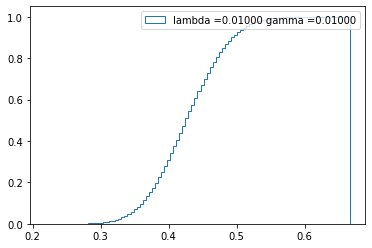

In [11]:
cdf(train_scores, 0)